HPA_KF
POTデータの範囲 15.12 ~ 35.22 POTデータ数: 161
最大尤度: 9.630662626828168e-32
最尤推定 ξ: -0.38190954773869346 σ: 8.2191181519979 RV: 34.82043610480725
RV： [33.54057934693409, 34.82043610480725, 39.58513589485206]
HFA_KF_c0
POTデータの範囲 15.03 ~ 35.11 POTデータ数: 131
最大尤度: 1.2785338519179753e-35
最尤推定 ξ: -0.5477386934673367 σ: 11.511732463577745 RV: 35.36568765594005
RV： [34.45079637693719, 35.36568765594005, 39.79497197491829]
HPA_YS
POTデータの範囲 15.15 ~ 29.44 POTデータ数: 99
最大尤度: 2.0488069942214115e-10
最尤推定 ξ: -0.46733668341708545 σ: 7.236550361033318 RV: 29.68834603689082
RV： [28.59563251826397, 29.68834603689082, 36.48219506675989]
HFA_YS_c0
POTデータの範囲 15.01 ~ 31.85 POTデータ数: 84
最大尤度: 2.0227585569561614e-11
最尤推定 ξ: -0.36180904522613067 σ: 6.992699104950136 RV: 31.980824718311922
RV： [30.118323359385876, 31.980824718311922, 43.30300122291408]


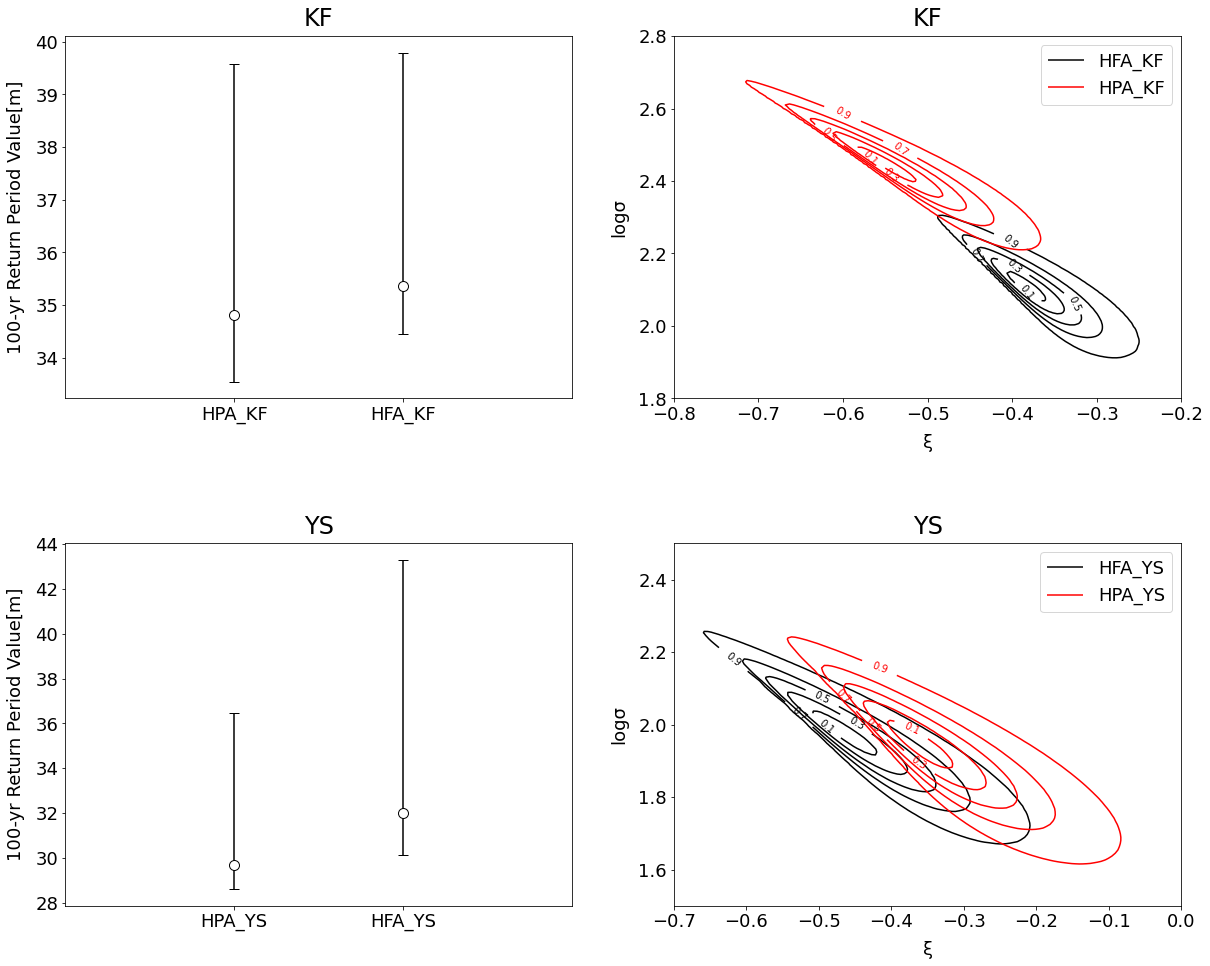

In [2]:
"""
それぞれのモデルのイベントごとの空間最大値を算出する.
それらの上位DATA_CNT個の点に対して, 極値統計解析を行い, 現在と過去で比較する
"""

from csv import reader
import matplotlib.pyplot as plt
import numpy as np
import func
import csv
import math

fig1 = plt.figure(figsize=(20, 16))

MODEL = ['KF', 'YS']
DATA_CNT = 50

for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'

        print(model)

        with open('../pot_csv(100)(thr=6)/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv(100)(thr=6)/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j])])
        
        # [Hsのindexがsortされる(小さい順)]
        DATA.sort()

        last_index = 0
        max_val = 0

        EVENT_POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[1] > 15.0:
                if data[0] > last_index + 24 * 7:
                    EVENT_POT.append([data[0], data[1]])
                    last_index = data[0]
                    max_val = data[1]
                else:
                    if data[1] > max_val:
                        EVENT_POT[-1] = [data[0], data[1]]
                        last_index = data[0]
                        max_val = data[1]
        
        EVENT_POT.pop(0)

        POT_DATA = []  # 空間最大波高
        for pot in EVENT_POT:
            POT_DATA.append(math.floor(pot[1] * 100) / 100)
        # 大きい順にsort
        POT_DATA.sort(reverse=True)
        # 書き出し
        with open(model + '_pot_data.csv', 'w') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(POT_DATA)

        print('POTデータの範囲', POT_DATA[-1], '~', POT_DATA[0], 'POTデータ数:', len(POT_DATA))
        
        if num == 0:  
            RV_, PARAM_ = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143*79*79, n0=len(POT_DATA), con=0.95)
            print('RV：', RV_)
        else:
            RV_0, PARAM_0 = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143*79*79, n0=len(POT_DATA), con=0.95)
            print('RV：', RV_0)


    # RVの描画
    ax1 = fig1.add_subplot(2, 2, model_num * 2 + 1)
    a = plt.errorbar(
        x=[1, 2],
        y=[RV_[1], RV_0[1]],
        yerr=np.array(
            [
                [RV_[1] - RV_[0], RV_0[1] - RV_0[0]],
                [RV_[2] - RV_[1], RV_0[2] - RV_0[1]]
            ]
        ),
        capsize=5,
        fmt='o',
        markersize=10,
        ecolor='black',
        markeredgecolor='black',
        color='w'
    )
    ax1.set_xlim((0, 3))
    ax1.set_title(model[4:6], fontsize=24, pad=10)
    ax1.set_xticks([1, 2])
    ax1.set_xticklabels(['HPA_' + model[4:6], 'HFA_' + model[4:6]], fontsize=18)
    ax1.set_ylabel('100-yr Return Period Value[m]', fontsize=18, labelpad=10)
    ax1.tick_params(axis='y', labelsize=18)

    # パラメータ等高線の描画
    ax2 = fig1.add_subplot(2, 2, model_num * 2 + 2)
    for i in range(2):
        PARAM = [PARAM_, PARAM_0][i]
        xi, sgm, sum_prob = PARAM
        log_sgm = [math.log(s) for s in sgm]
        X, Y = np.meshgrid(xi, log_sgm)
        Z = np.array([[sum_prob[i, j] for i in range(200)] for j in range(200)])
        if i == 0:  # 過去
            cntr = ax2.contour(X, Y, Z, levels=[0.1, 0.3, 0.5, 0.7, 0.9], colors='black')
            h1,_ = cntr.legend_elements()
        else:  # 未来
            cntr = ax2.contour(X, Y, Z, levels=[0.1, 0.3, 0.5, 0.7, 0.9], colors='red')
            h2,_ = cntr.legend_elements()
        ax2.clabel(cntr)
    ax2.legend([h1[0], h2[0]], ['HFA_' + MODEL[model_num], 'HPA_' + MODEL[model_num]], fontsize=18)
    if model_num == 0:
        ax2.set_xlim((-0.8, -0.2))
        ax2.set_ylim((1.8, 2.8))
    else:
        ax2.set_xlim((-0.7, 0))
        ax2.set_ylim((1.5, 2.5))
    ax2.set_title(model[4:6], fontsize=24, pad=10)
    ax2.set_xlabel("ξ", fontsize=18, labelpad=10)
    ax2.set_ylabel("logσ", fontsize=18, labelpad=10)
    ax2.tick_params(axis='x', labelsize=18)
    ax2.tick_params(axis='y', labelsize=18)

plt.subplots_adjust(hspace=0.4)
plt.savefig("../img/100y-rv_of_stm.png")
plt.show()